# Importazione librerie

In [67]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
from datetime import datetime
import numpy as np

# Function

In [68]:
def download_and_plot(cryptos, timeframe, start_date, end_date, plot):
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [69]:
def simulate_rebalancing_strategy(dati, allocazioni_iniziali, timeframe, valore_iniziale_portafoglio):
    """
    Simula una strategia di ribilanciamento del portafoglio di crypto.

    Parametri:
    - dati: DataFrame con i prezzi delle crypto (righe=giorni, colonne=symbol), con un timestamp.
    - allocazioni_iniziali: Dizionario con le percentuali di allocazione iniziale per ogni crypto.
    - timeframe: Numero di giorni tra un ribilanciamento e l'altro.

    Ritorna:
    - DataFrame con timestamp, prezzi, quantità di token, controvalori e valore totale del portafoglio.
    """
    # Verifica che le allocazioni iniziali sommino a 1
    assert isclose(sum(allocazioni_iniziali.values()), 1, abs_tol=1e-9), "Le allocazioni iniziali devono sommare a 1."
    
    # Inizializza le quantità iniziali di ciascuna crypto
    prezzi_iniziali = dati.iloc[0]
    quantita_token = {crypto: (valore_iniziale_portafoglio * allocazioni_iniziali[crypto]) / prezzi_iniziali[crypto] for crypto in dati.columns}
    
    # Lista per salvare i risultati
    risultati = []

    # Simulazione giorno per giorno
    for i, (timestamp, prezzi) in enumerate(dati.iterrows()):
        # Calcola il valore totale attuale del portafoglio
        controvalori = {crypto: quantita_token[crypto] * prezzi[crypto] for crypto in dati.columns}
        valore_totale_portafoglio = sum(controvalori.values())
        
        # Salva i dati del giorno
        risultato_giorno = {
            'timestamp': timestamp,
            **{f'prezzo_{crypto}': prezzi[crypto] for crypto in dati.columns},
            **{f'quantita_{crypto}': quantita_token[crypto] for crypto in dati.columns},
            **{f'controvalore_{crypto}': controvalori[crypto] for crypto in dati.columns},
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        risultati.append(risultato_giorno)
        
        # Ribilanciamento ogni `timeframe` giorni
        if i > 0 and i % timeframe == 0:
            # Calcola i valori target per ciascuna crypto
            valori_target = {crypto: valore_totale_portafoglio * allocazioni_iniziali[crypto] for crypto in dati.columns}
            
            # Vendere crypto sopra il target
            # liquidita = 0
            for crypto in dati.columns:
                if controvalori[crypto] > valori_target[crypto]:
                    # Vendi l'eccesso e accumula liquidità
                    eccedenza = controvalori[crypto] - valori_target[crypto]
                    quantita_token[crypto] -= eccedenza / prezzi[crypto]
                    # liquidita += eccedenza
            
            # Comprare crypto sotto il target
            for crypto in dati.columns:
                if controvalori[crypto] < valori_target[crypto]:
                    # Usa la liquidità per comprare la quantità mancante
                    deficit = valori_target[crypto] - controvalori[crypto]
                    quantita_token[crypto] += deficit / prezzi[crypto]
                    # liquidita -= acquisto

    # Converti i risultati in DataFrame
    risultati_df = pd.DataFrame(risultati)
    return risultati_df

In [70]:
def calcola_fattori_di_variazione(crypto_prices):
    """
    Calcola i fattori di variazione dei prezzi giornalieri per ogni crypto e aggiunge una colonna
    con il prodotto dei fattori di variazione giornalieri.
    
    Parametri:
    - crypto_prices: DataFrame con i prezzi giornalieri di ogni crypto (righe=giorni, colonne=crypto).
    
    Ritorna:
    - df_fattori: DataFrame con i fattori di variazione e una colonna aggiuntiva per il prodotto dei fattori.
    - metriche: Serie con le medie delle colonne.
    """
    # Calcola i fattori di variazione (rapporto tra il prezzo corrente e quello del giorno precedente)
    fattori_variazione = crypto_prices / crypto_prices.shift(1)
    
    # Aggiungi una colonna per il prodotto dei fattori di variazione giornalieri
    fattori_variazione['prodotto_fattori'] = fattori_variazione.prod(axis=1)
    
    # Calcola metriche numeriche (ad esempio le medie)
    metriche = fattori_variazione.mean()
    
    return fattori_variazione, metriche

# Simulazione

## Scaricamento dati

In [71]:
allocazioni_iniziali = {'BTC': 0.6, 'ETH': 0.3, 'SOL': 0.05, 'DOGE':0.05}
cryptos = list(allocazioni_iniziali.keys())  # Specifica le crypto
timeframe = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2021-01-01'  # Data di inizio
end_date = '2021-12-31'  # Data di fine
plot = False

data_frames = download_and_plot(cryptos, timeframe, start_date, end_date, plot)

Scarico i dati per BTC/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per ETH/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per SOL/USDT dal 2021-01-01 al 2021-12-31...
Scarico i dati per DOGE/USDT dal 2021-01-01 al 2021-12-31...


In [43]:
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[cryptos[0]].index
for crypto in cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices

,BTC,ETH,SOL,DOGE
timestamp,,,,
2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679
2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737
2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755
2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978
2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894
...,...,...,...,...
2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100
2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800
2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000


In [44]:
crypto_prices.isna().sum().sum()

np.int64(0)

## Strategia di ribilanciamento

In [45]:
timeframe = 24
valore_iniziale_portafoglio = 100

risultati_df = simulate_rebalancing_strategy(crypto_prices, allocazioni_iniziali, timeframe, valore_iniziale_portafoglio)
risultati_df

,timestamp,prezzo_BTC,prezzo_ETH,prezzo_SOL,prezzo_DOGE,quantita_BTC,quantita_ETH,quantita_SOL,quantita_DOGE,controvalore_BTC,controvalore_ETH,controvalore_SOL,controvalore_DOGE,valore_totale_portafoglio
0,2021-01-01 00:00:00,28995.13,734.07,1.5442,0.004679,0.002069,0.040868,3.237923,1068.650081,60.000000,30.000000,5.000000,5.000000,100.000000
1,2021-01-01 01:00:00,29409.99,748.28,1.5734,0.004737,0.002069,0.040868,3.237923,1068.650081,60.858475,30.580735,5.094547,5.061661,101.595418
2,2021-01-01 02:00:00,29194.65,744.06,1.5872,0.004755,0.002069,0.040868,3.237923,1068.650081,60.412869,30.408272,5.139231,5.081538,101.041910
3,2021-01-01 03:00:00,29278.40,744.82,1.6029,0.004978,0.002069,0.040868,3.237923,1068.650081,60.586174,30.439331,5.190066,5.319847,101.535419
4,2021-01-01 04:00:00,29220.31,742.29,1.6022,0.004894,0.002069,0.040868,3.237923,1068.650081,60.465968,30.335935,5.187800,5.229760,101.219462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2021-12-30 20:00:00,47203.16,3724.78,173.1900,0.171100,0.005530,0.035201,0.125077,126.279545,261.047329,131.114869,21.662137,21.606430,435.430765
8720,2021-12-30 21:00:00,47300.00,3736.93,173.2000,0.171800,0.005530,0.035201,0.125077,126.279545,261.582882,131.542558,21.663388,21.694826,436.483653
8721,2021-12-30 22:00:00,47084.88,3703.83,171.6800,0.171000,0.005530,0.035201,0.125077,126.279545,260.393205,130.377415,21.473270,21.593802,433.837692
8722,2021-12-30 23:00:00,47120.87,3709.27,172.5200,0.171100,0.005530,0.035201,0.125077,126.279545,260.592241,130.568906,21.578335,21.606430,434.345912


In [46]:
fattore_rendimento_totale = risultati_df['valore_totale_portafoglio'].iloc[-1] / risultati_df['valore_totale_portafoglio'].iloc[0]
fattore_rendimento_totale

np.float64(4.338481786211867)

In [47]:
mdp.calcola_principali_metriche(risultati_df['valore_totale_portafoglio'])

{'Total Return': np.float64(333.84817862118666),
 'Max Drawdown': 53.263043776835296,
 'Volatility': np.float64(0.15677830820270153),
 'Sharpe Ratio': np.float64(0.3491506285910352),
 'Sortino Ratio': np.float64(0.5438245993386294),
 'Calmar Ratio': np.float64(6.267914015953798),
 'Profit Factor': 'Non calcolabile: dati insufficienti',
 'PnL': 'Non calcolabile: dati insufficienti'}

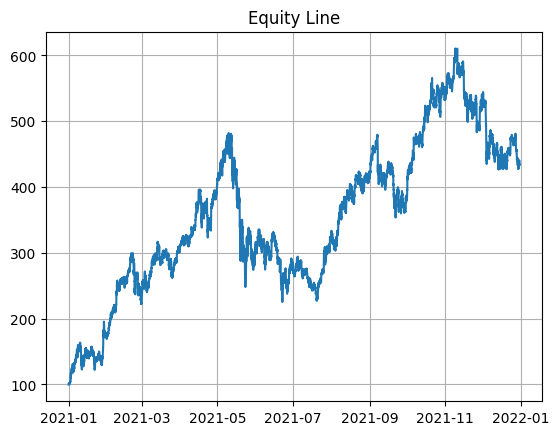

In [48]:
plt.title('Equity Line')
plt.grid()
plt.plot(risultati_df['timestamp'], risultati_df['valore_totale_portafoglio']);

In [49]:
fattori_df, metriche = calcola_fattori_di_variazione(crypto_prices)

# Stampa dei risultati
print("Fattori di variazione:")
display(fattori_df)

print("\nMetriche (medie delle colonne):")
metriche

Fattori di variazione:


,BTC,ETH,SOL,DOGE,prodotto_fattori
timestamp,,,,,
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,1.000000
2021-01-01 01:00:00,1.014308,1.019358,1.018909,1.012332,1.066486
2021-01-01 02:00:00,0.992678,0.994360,1.008771,1.003927,0.999647
2021-01-01 03:00:00,1.002869,1.001021,1.009892,1.046897,1.061368
2021-01-01 04:00:00,0.998016,0.996603,0.999563,0.983066,0.977356
...,...,...,...,...,...
2021-12-30 20:00:00,0.992531,0.992994,0.993461,0.990735,0.970061
2021-12-30 21:00:00,1.002052,1.003262,1.000058,1.004091,1.009491
2021-12-30 22:00:00,0.995452,0.991142,0.991224,0.995343,0.973422



Metriche (medie delle colonne):


BTC                 1.000098
ETH                 1.000254
SOL                 1.000715
DOGE                1.000717
prodotto_fattori    1.002441
dtype: float64

# Studio come varia nel tempo l'asset allocation ideale per le crypto scelte

## Ottengo l'elenco delle crypto scaricabili da un certo exchamge

In [ ]:
def get_available_cryptos(exchange_name, timeframe, start_date, end_date):
    """
    Ottiene l'elenco delle crypto disponibili in un periodo specificato senza valori NaN.

    Parametri:
    - exchange_name: Nome dell'exchange (es. 'binance').
    - timeframe: Timeframe scelto (es. '1d', '1h').
    - start_date: Data di inizio (stringa 'YYYY-MM-DD').
    - end_date: Data di fine (stringa 'YYYY-MM-DD').

    Ritorna:
    - Lista di simboli crypto disponibili.
    """
    # Inizializza l'exchange CCXT
    exchange = getattr(ccxt, exchange_name)()

    # Converte le date in timestamp UNIX (ms)
    since = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    until = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)

    # Ottieni l'elenco dei mercati disponibili
    markets = exchange.load_markets()
    symbols = [market for market in markets.keys()]

    # Lista per salvare le crypto disponibili
    available_cryptos = []

    for symbol in symbols:
        try:
            # Scarica i dati OHLCV
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=None)
            
            # Converte i dati in DataFrame
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            
            # Filtra per il periodo specificato
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
            
            # Verifica se ci sono valori NaN
            if not df.isnull().values.any():
                print(f'Trovato il pair {symbol}')
                available_cryptos.append(symbol)
            else:
                print(f'Il pair {symbol} ha dei NaN')
        
        except Exception as e:
            # Ignora gli errori (ad esempio mercati non supportati nel periodo scelto)
            print(f"Errore con il simbolo {symbol}: {e}")

    return available_cryptos

Trovato il pair ETH/BTC
Trovato il pair LTC/BTC
Trovato il pair BNB/BTC
Trovato il pair NEO/BTC
Trovato il pair QTUM/ETH
Trovato il pair EOS/ETH
Trovato il pair SNT/ETH
Trovato il pair BNT/ETH
Trovato il pair BCC/BTC
Trovato il pair GAS/BTC
Trovato il pair BNB/ETH
Trovato il pair BTC/USDT
Trovato il pair ETH/USDT
Trovato il pair HSR/BTC
Trovato il pair OAX/ETH
Trovato il pair DNT/ETH
Trovato il pair MCO/ETH
Trovato il pair ICN/ETH
Trovato il pair MCO/BTC
Trovato il pair WTC/BTC
Trovato il pair WTC/ETH
Trovato il pair LRC/BTC
Trovato il pair LRC/ETH
Trovato il pair QTUM/BTC
Trovato il pair YOYOW/BTC
Trovato il pair OMG/BTC
Trovato il pair OMG/ETH
Trovato il pair ZRX/BTC
Trovato il pair ZRX/ETH
Trovato il pair STRAT/BTC
Trovato il pair STRAT/ETH
Trovato il pair SNGLS/BTC
Trovato il pair SNGLS/ETH
Trovato il pair BQX/BTC
Trovato il pair BQX/ETH
Trovato il pair KNC/BTC
Trovato il pair KNC/ETH
Trovato il pair FUN/BTC
Trovato il pair FUN/ETH
Trovato il pair SNM/BTC
Trovato il pair SNM/ETH
Tr

In [ ]:
exchange_name = 'binance'  # Nome dell'exchange
timeframe = '1d'  # Timeframe (es. '1d' per giornaliero)
start_date = '2021-01-01'  # Data di inizio
end_date = '2021-12-31'  # Data di fine

available_cryptos = get_available_cryptos(exchange_name, timeframe, start_date, end_date)
print("Crypto disponibili:", available_cryptos)

In [51]:
len(available_cryptos)

3166

In [62]:
available_cryptos_usdt = [symbol.split('/USDT')[0] for symbol in available_cryptos if symbol.endswith('/USDT')]
len(available_cryptos_usdt)

529

In [63]:
available_cryptos_usdt

['BTC',
 'ETH',
 'BNB',
 'BCC',
 'NEO',
 'LTC',
 'QTUM',
 'ADA',
 'XRP',
 'EOS',
 'TUSD',
 'IOTA',
 'XLM',
 'ONT',
 'TRX',
 'ETC',
 'ICX',
 'VEN',
 'NULS',
 'VET',
 'PAX',
 'BCHABC',
 'BSV',
 'USDC',
 'LINK',
 'WAVES',
 'BTT',
 'USDS',
 'ONG',
 'HOT',
 'ZIL',
 'ZRX',
 'FET',
 'BAT',
 'XMR',
 'ZEC',
 'IOST',
 'CELR',
 'DASH',
 'NANO',
 'OMG',
 'THETA',
 'ENJ',
 'MITH',
 'MATIC',
 'ATOM',
 'TFUEL',
 'ONE',
 'FTM',
 'ALGO',
 'USDSB',
 'GTO',
 'ERD',
 'DOGE',
 'DUSK',
 'ANKR',
 'WIN',
 'COS',
 'NPXS',
 'COCOS',
 'MTL',
 'TOMO',
 'PERL',
 'DENT',
 'MFT',
 'KEY',
 'STORM',
 'DOCK',
 'WAN',
 'FUN',
 'CVC',
 'CHZ',
 'BAND',
 'BUSD',
 'BEAM',
 'XTZ',
 'REN',
 'RVN',
 'HC',
 'HBAR',
 'NKN',
 'STX',
 'KAVA',
 'ARPA',
 'IOTX',
 'RLC',
 'MCO',
 'CTXC',
 'BCH',
 'TROY',
 'VITE',
 'FTT',
 'EUR',
 'OGN',
 'DREP',
 'BULL',
 'BEAR',
 'ETHBULL',
 'ETHBEAR',
 'TCT',
 'WRX',
 'BTS',
 'LSK',
 'BNT',
 'LTO',
 'EOSBULL',
 'EOSBEAR',
 'XRPBULL',
 'XRPBEAR',
 'STRAT',
 'AION',
 'MBL',
 'COTI',
 'BNBBULL',
 'BNB

## Fissato un insieme di crypto, un timeframe e un periodo, cerco la miglior AA

In [ ]:
def generate_allocations(cryptos, precision):
    """
    Genera tutte le possibili combinazioni di asset allocation per un numero di crypto specificato.

    Parametri:
    - cryptos: Lista delle crypto selezionate.
    - precision: Precisione delle allocazioni (0 significa interi, 1 significa 1 decimale, etc.).

    Ritorna:
    - Lista di dizionari con le possibili allocazioni.
    """
    step = 10 ** -precision  # Es. precision=1 -> step=0.1
    # num_steps = int(1 / step) + 1

    # Genera tutte le combinazioni di allocazioni
    ranges = [np.arange(0, 1 + step, step) for _ in cryptos]
    all_combinations = [combo for combo in itertools.product(*ranges) if isclose(sum(combo), 1, abs_tol=1e-9)]

    # Converti in dizionario con i nomi delle crypto
    allocations = [dict(zip(cryptos, combo)) for combo in all_combinations]
    return allocations

In [98]:
def find_best_allocation_with_download(
    chosen_cryptos, 
    timeframe_download,
    timeframe, 
    start_date, 
    end_date, 
    precision, 
    exchange_name='binance'
):
    """
    Trova la miglior asset allocation scaricando i dati delle crypto e massimizzando il rendimento.

    Parametri:
    - chosen_cryptos: Lista delle crypto selezionate.
    - timeframe: Timeframe scelto per il ribilanciamento (ad esempio '1d', '1h').
    - start_date: Data di inizio (formato 'YYYY-MM-DD').
    - end_date: Data di fine (formato 'YYYY-MM-DD').
    - precision: Precisione delle allocazioni (es. 1 significa step di 0.1%).
    - exchange_name: Nome dell'exchange da cui scaricare i dati (default: 'binance').

    Ritorna:
    - Dizionario con la miglior allocazione e il rendimento massimo.
    """
    # Scarica i dati con la tua funzione `download_and_plot`
    data_frames = download_and_plot(chosen_cryptos, timeframe_download, start_date, end_date, plot=False)

    # Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
    crypto_prices = pd.DataFrame()
    crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
    for crypto in chosen_cryptos:
        # print(crypto)
        # display(data_frames[crypto]['close'].values)
        crypto_prices[crypto] = data_frames[crypto]['close'].values
    crypto_prices.set_index('timestamp', inplace=True)

    # Filtra il DataFrame per il periodo specificato
    dati_periodo = crypto_prices[
        (crypto_prices.index >= pd.Timestamp(start_date)) & 
        (crypto_prices.index <= pd.Timestamp(end_date))
    ]

    # Genera tutte le possibili combinazioni di allocazioni
    allocations = generate_allocations(chosen_cryptos, precision)

    best_allocation = None
    best_return = -np.inf

    # Valore iniziale del portafoglio
    valore_iniziale_portafoglio = 100

    # Simula ogni allocazione e trova la migliore
    for allocation in allocations:
        # Simula la strategia di ribilanciamento per l'allocazione corrente
        risultati_df = simulate_rebalancing_strategy(
            dati_periodo, allocation, timeframe, valore_iniziale_portafoglio
        )

        # Calcola il rendimento totale
        rendimento = risultati_df['valore_totale_portafoglio'].iloc[-1] / risultati_df['valore_totale_portafoglio'].iloc[0]
        print(f'Asset Allocation: {allocation} -> Rendimento: {rendimento}')

        # Aggiorna la miglior allocazione se necessario
        if rendimento > best_return:
            best_return = rendimento
            best_allocation = allocation

    return {'allocazione': best_allocation, 'rendimento': best_return}

In [ ]:
# Esempio di utilizzo
chosen_cryptos = ['BTC', 'ETH', 'LINK', 'SOL', 'DOGE', 'RNDR']  # Le crypto da analizzare
timeframe_download = '1d'
timeframe = 7  # Ribilanciamento settimanale
start_date = '2022-01-01'
end_date = '2022-12-31'
precision = 2  # Precisione delle allocazioni (ad esempio 1 decimale)

# Trova la miglior asset allocation
result = find_best_allocation_with_download(chosen_cryptos, timeframe_download, timeframe, start_date, end_date, precision)
print("Miglior allocazione:", result['allocazione'])
print("Rendimento massimo:", result['rendimento'])

Scarico i dati per BTC/USDT dal 2022-01-01 al 2022-12-31...
Scarico i dati per ETH/USDT dal 2022-01-01 al 2022-12-31...
Scarico i dati per LINK/USDT dal 2022-01-01 al 2022-12-31...
Scarico i dati per SOL/USDT dal 2022-01-01 al 2022-12-31...
Scarico i dati per DOGE/USDT dal 2022-01-01 al 2022-12-31...
Scarico i dati per RNDR/USDT dal 2022-01-01 al 2022-12-31...
